In [171]:
# type: ignore
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [172]:
words = open('data/names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [173]:
len(words)

32033

In [174]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


#### training split, dev/validation split, test split
#### 80%, 10%, 10%

In [175]:
def build_dataset(words):
    # dataset creation
    context_length = 3
    # , labels
    X, Y = [], []

    for w in words:
        context = [0] * context_length
        
        for char in w + '.':
            ind = stoi[char]
            X.append(context)
            Y.append(ind)
            # print(''.join(itos[i] for i in context), '-->', itos[ind])
            context = context[1:] + [ind]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    print(X.shape, Y.shape)
    
    return X, Y

random.shuffle(words)
train_split = int(len(words) * 0.8)
val_split = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:train_split])
Xval, Yval = build_dataset(words[train_split:val_split])
Xtest, Ytest = build_dataset(words[val_split:])


torch.Size([182597, 3]) torch.Size([182597])
torch.Size([22837, 3]) torch.Size([22837])
torch.Size([22712, 3]) torch.Size([22712])


In [176]:
X.shape, X.dtype, Y.shape, Y.dtype # type: ignore

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [177]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [178]:
# create 2-dimensional embeddings for each character
C = torch.randn((27, 2))
print(C.shape)
C

torch.Size([27, 2])


tensor([[ 0.0097,  1.1059],
        [-0.2312, -0.2652],
        [ 2.4136,  1.6263],
        [-0.2230,  0.5724],
        [ 1.7115,  0.6244],
        [ 0.4503, -0.6984],
        [ 0.3734,  0.5711],
        [-0.6252,  0.2163],
        [-0.5373,  0.3184],
        [-0.8093, -1.5222],
        [-0.1733,  0.7407],
        [-1.0942,  0.5502],
        [-0.3175, -1.3975],
        [ 0.4505,  1.6968],
        [ 1.4383,  0.2830],
        [-0.1143, -1.0686],
        [-0.1839, -0.6168],
        [-0.6432, -0.6020],
        [-0.0370, -0.0534],
        [ 0.5060,  1.0866],
        [ 0.1992, -0.2079],
        [-0.0639,  0.9626],
        [-1.4318,  0.0240],
        [-0.0686,  0.0570],
        [ 0.3917, -0.1732],
        [-1.4842, -0.6347],
        [ 0.3929,  1.4288]])

In [179]:
# the embedding of 'd'
C[5]

tensor([ 0.4503, -0.6984])

In [180]:
# Note that this is equivalent to the above cell
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.4503, -0.6984])

In [181]:
# we can also index into C using the entire X tensor
# this has replaced each index in X with its embedding
emb = C[X]
C[X].shape

torch.Size([228146, 3, 2])

![Bengio et al. Architecture](images/bengioetal.png)

In [182]:
# first hidden layer
# 6 (each context piece has 3 embeddings of size 2) inputs to each of 100 (arbitrary) neurons
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [183]:
# emb.shape => (32, 3, 2) and W1 => (6, 100)
hidden_layer_one = emb.view(emb.shape[0], 6) @ W1 + b1
# tanh => [0, 1]
hidden_layer_one = torch.tanh(hidden_layer_one)
hidden_layer_one.shape

torch.Size([228146, 100])

In [184]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [185]:
# logits === final outputs
logits = hidden_layer_one @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [186]:
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

3481

### Softmax!

![Softmax in Neural Nets](images/softmax.png)

In [187]:

# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# # prob[torch.arange(32), Y] is the probability from each row that goes into the correct label y
# loss = -prob[torch.arange(32), Y].log().mean()

# built in function to perform the above operations
# prefer built in's over manual lines for baked in efficiency (for example not creating new tensors in memory) which makes the backwards passes faster
loss = F.cross_entropy(logits, Y)
loss

tensor(20.6174)

### Training loop

In [188]:
# training dataset
Xtr.shape, Ytr.shape

(torch.Size([182597, 3]), torch.Size([182597]))

In [189]:
# clean parameter initialization
C = torch.randn((27, 10))
W1 = torch.randn((30, 200))
b1 = torch.randn(200)
W2 = torch.randn((200, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

11897

In [190]:
for p in parameters:
    p.requires_grad = True

In [191]:
# learning rate exp
lre = torch.linspace(-3, 0, 1000)
# learning rate step
lrs = 10 ** lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [192]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(50000):
    # create a minibatch
    # a minibatch trains the model on a *different* subset of data each time, meaning that the gradient direction in our backprop isn't exact, but close enough to be useful
    # 32 row indexes from X to use
    ind = torch.randint(0, Xtr.shape[0], (32,))
    
    # forwards pass
    emb = C[Xtr[ind]]
    
    hidden_layer_one = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)

    logits = hidden_layer_one @ W2 + b2

    loss = F.cross_entropy(logits, Ytr[ind])
    
    # print(loss.item())
    
    # backwards pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # finding a good learning rate
    # lr = lrs[i]
    lr = 0.1 if i < 25000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # finding a good learning rate stats
    # lri.append(lre[i].item())
    stepi.append(i)
    lossi.append(loss.log10().item())

# loss for those minibatches
# print(loss.item())

In [ ]:
# loss for last batch (no real significance)
loss.item()

2.1671481132507324

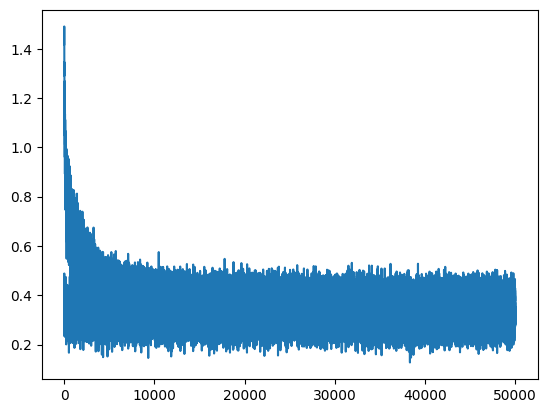

In [208]:
plt.plot(stepi, lossi)

In [209]:
# total model loss using training set
emb = C[Xtr]
hidden_layer_one = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)
logits = hidden_layer_one @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1477, grad_fn=<NllLossBackward0>)

In [210]:
# total model loss using dev set
emb = C[Xval]
hidden_layer_one = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)
logits = hidden_layer_one @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.1717, grad_fn=<NllLossBackward0>)

#### Sampling from the Model

In [211]:
for _ in range(20):
    out = []
    context = [0] * context_length
    
    while True:
        emb = C[torch.tensor([context])]
        
        hidden_layer_one = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = hidden_layer_one @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        ind = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ind]
        out.append(ind)
        
        if ind == 0:
            break
    
    print(''.join(itos[i] for i in out))

dau.
jostina.
neranda.
parahtian.
sukhazy.
ayuva.
ayarena.
kunna.
abdurylina.
ceyad.
keil.
geb.
rockier.
dis.
leigh.
cony.
var.
mangela.
ever.
muhagenores.
